In [67]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0).T
meth_df = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0).T
cnv_df  = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0).T

# apply standard scaling to all data
scaler_meth = StandardScaler()
meth_df = pd.DataFrame(
    scaler_meth.fit_transform(meth_df.T).T,
    index=meth_df.index,
    columns=meth_df.columns
)

scaler_cnv = StandardScaler()
cnv_df = pd.DataFrame(
    scaler_cnv.fit_transform(cnv_df.T).T,
    index=cnv_df.index,
    columns=cnv_df.columns
)
scaler_gene = StandardScaler()
gene_df = pd.DataFrame(
    scaler_gene.fit_transform(gene_df.T).T,
    index=gene_df.index,
    columns=gene_df.columns
)

print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")

After transpose - Shapes (samples x features):
gene_df: (205, 44663)
meth_df: (205, 419542)
cnv_df: (205, 56756)


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [69]:
print("NaN counts:", gene_df.isna().sum().sum(),
      meth_df.isna().sum().sum(),
      cnv_df.isna().sum().sum())

NaN counts: 0 0 0


In [70]:
gene_df = gene_df.fillna(0.0)
meth_df = meth_df.fillna(0.0)
cnv_df  = cnv_df.fillna(0.0)

In [71]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Align samples across all three omics
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]

print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)

Shapes: (205, 44663) (205, 419542) (205, 56756)
Shapes: (205, 44663) (205, 419542) (205, 56756)


Epoch 10/200 | Train Loss: 0.1216 | Val Loss: 0.0073
Epoch 20/200 | Train Loss: 0.0674 | Val Loss: 0.0031
Early stopping triggered!


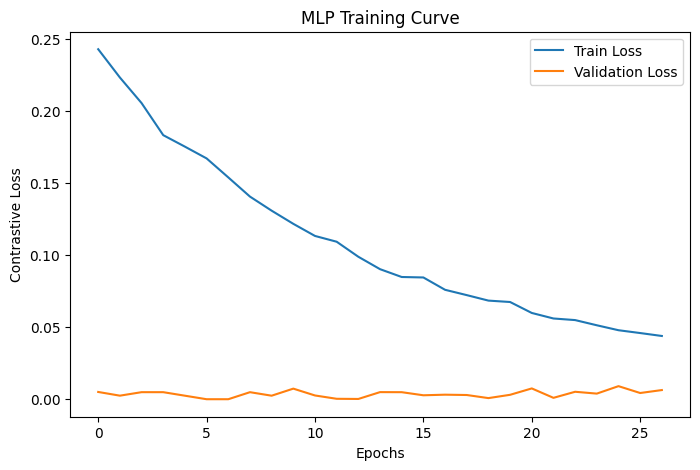

Epoch 10/200 | Train Loss: 0.1076 | Val Loss: 0.0002
Epoch 20/200 | Train Loss: 0.0579 | Val Loss: 0.0014
Early stopping triggered!


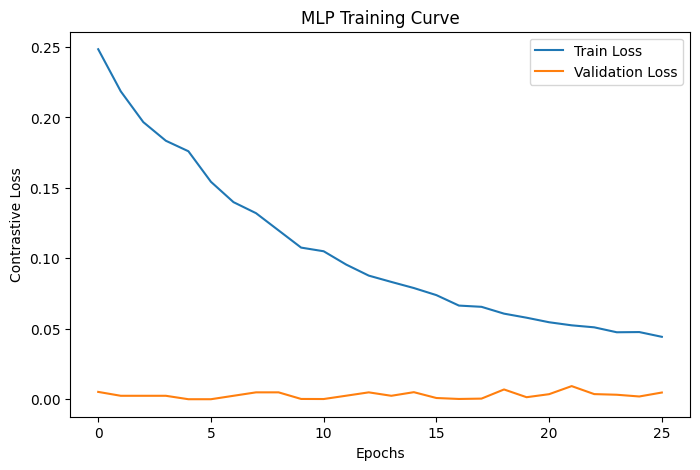

Epoch 10/200 | Train Loss: 0.1411 | Val Loss: 0.0024
Epoch 20/200 | Train Loss: 0.0821 | Val Loss: 0.0024
Epoch 30/200 | Train Loss: 0.0508 | Val Loss: 0.0028
Early stopping triggered!


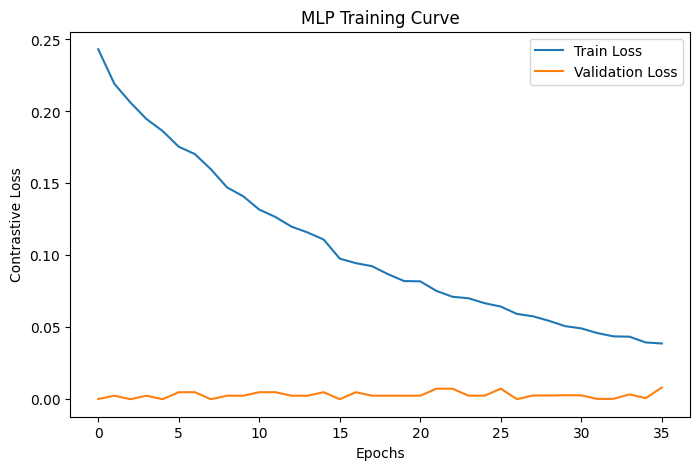

Fused latent shape: torch.Size([205, 192])


In [96]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

# ------------------ MLP Feature Extractor with Dropout ------------------
class MLP(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(MLP, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        return self.feature_extractor(x)

# ------------------ Training with contrastive learning approach ------------------
def train_mlp(model, data, epochs=200, patience=20, normalize=True):
    # Optionally normalize features to mean=0, std=1
    if normalize:
        scaler = StandardScaler()
        data_np = scaler.fit_transform(data.cpu().numpy())
    else:
        data_np = data.cpu().numpy()

    # Split into train/val
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # For unsupervised feature learning, we use a simple contrastive approach
    # We create positive pairs by adding small noise and negative pairs from different samples
    def create_pairs(X, noise_std=0.1):
        # Positive pairs: original + noisy version
        noise = torch.randn_like(X) * noise_std
        X_pos = X + noise
        
        # Negative pairs: random shuffle
        idx = torch.randperm(X.size(0))
        X_neg = X[idx]
        
        return X_pos, X_neg

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        
        # Create positive and negative pairs
        X_pos, X_neg = create_pairs(X_train)
        
        # Get embeddings
        z_orig = model(X_train)
        z_pos = model(X_pos)
        z_neg = model(X_neg)
        
        # Contrastive loss: pull positive pairs together, push negative pairs apart
        pos_loss = torch.mean((z_orig - z_pos) ** 2)
        neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_orig - z_neg, dim=1), min=0) ** 2)
        loss = pos_loss + 0.1 * neg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation - use same approach
        model.eval()
        with torch.no_grad():
            X_val_pos, X_val_neg = create_pairs(X_val)
            z_val_orig = model(X_val)
            z_val_pos = model(X_val_pos)
            z_val_neg = model(X_val_neg)
            
            val_pos_loss = torch.mean((z_val_orig - z_val_pos) ** 2)
            val_neg_loss = torch.mean(torch.clamp(1.0 - torch.norm(z_val_orig - z_val_neg, dim=1), min=0) ** 2)
            val_loss = val_pos_loss + 0.1 * val_neg_loss

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Contrastive Loss")
    plt.title("MLP Training Curve")
    plt.legend()
    plt.show()

    return model

# ------------------ Train per omic ------------------
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]

mlp_gene = MLP(gene_dim, latent_dim=64).to(device)
mlp_meth = MLP(meth_dim, latent_dim=64).to(device)
mlp_cnv  = MLP(cnv_dim,  latent_dim=64).to(device)

mlp_gene = train_mlp(mlp_gene, gene, normalize=True)
mlp_meth = train_mlp(mlp_meth, meth, normalize=True)
mlp_cnv  = train_mlp(mlp_cnv, cnv, normalize=True)

# ------------------ Extract latents & fuse ------------------
mlp_gene.eval(); mlp_meth.eval(); mlp_cnv.eval()
with torch.no_grad():
    z_gene = mlp_gene(gene.to(device))
    z_meth = mlp_meth(meth.to(device))
    z_cnv  = mlp_cnv(cnv.to(device))

z_fused = torch.cat([z_gene, z_meth, z_cnv], dim=1)
print("Fused latent shape:", z_fused.shape)

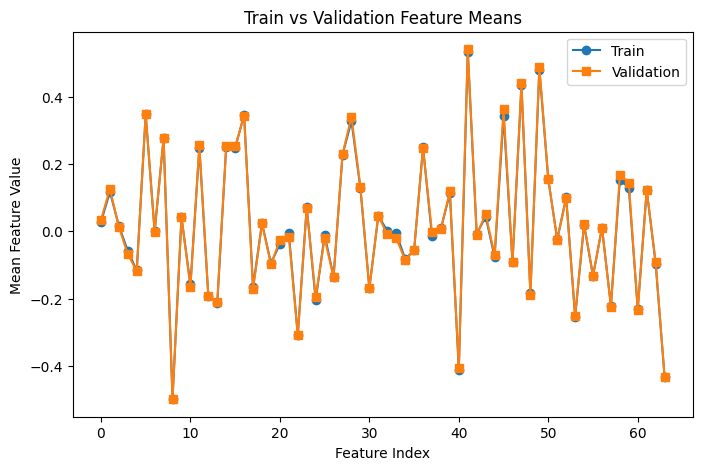

Train features shape: (164, 64) | Val features shape: (41, 64)
Epoch 10/200 | Train Loss: 0.1251 | Val Loss: 0.0000
Epoch 20/200 | Train Loss: 0.0678 | Val Loss: 0.0040
Epoch 30/200 | Train Loss: 0.0395 | Val Loss: 0.0082
Early stopping triggered!


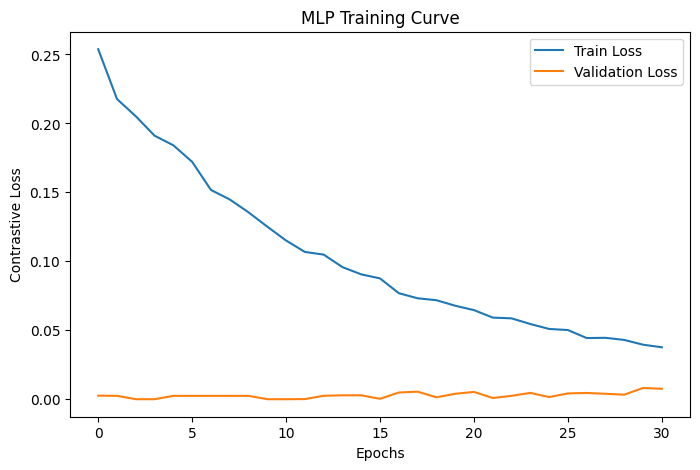

Epoch 10/200 | Train Loss: 0.1195 | Val Loss: 0.0000
Epoch 20/200 | Train Loss: 0.0637 | Val Loss: 0.0073
Epoch 30/200 | Train Loss: 0.0396 | Val Loss: 0.0034
Early stopping triggered!


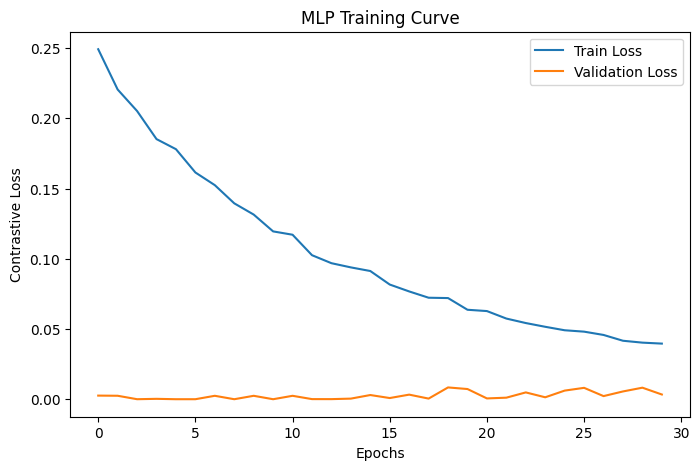

Latent stability (corr between runs): -0.150
Silhouette on fused latents: 0.12930281460285187


In [97]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# ------------------ Diagnostics ------------------
def feature_distribution(model, X_train_np, X_val_np, device):
    """Compute and plot per-sample feature distributions for train/val."""
    def get_features(X_np):
        model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X_np, dtype=torch.float32).to(device)
            z = model(X_t)
        return z.cpu().numpy()

    features_train = get_features(X_train_np)
    features_val   = get_features(X_val_np)

    # Plot feature means
    plt.figure(figsize=(8,5))
    plt.plot(features_train.mean(axis=0), label="Train", marker='o')
    plt.plot(features_val.mean(axis=0), label="Validation", marker='s')
    plt.xlabel("Feature Index")
    plt.ylabel("Mean Feature Value")
    plt.title("Train vs Validation Feature Means")
    plt.legend()
    plt.show()

    print(f"Train features shape: {features_train.shape} | Val features shape: {features_val.shape}")

    return features_train, features_val

def latent_stability_check(model_class, data, latent_dim, device, n_runs=2):
    """Train MLP multiple times and check correlation between latent spaces."""
    latents = []
    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = model_class(data.shape[1], latent_dim=latent_dim).to(device)
        model = train_mlp(model, data, normalize=True)
        with torch.no_grad():
            z = model(data.to(device))
        latents.append(z.cpu().numpy())

    # Compare pairwise correlations
    corr = np.corrcoef(latents[0].ravel(), latents[1].ravel())[0,1]
    print(f"Latent stability (corr between runs): {corr:.3f}")

    return corr

# ------------------ Example usage ------------------
# After training each MLP, run diagnostics:
# (inside train_mlp, you already split train/val)

# 1. Check per-sample feature distributions
X_train_np, X_val_np = train_test_split(gene.cpu().numpy(), test_size=0.2, random_state=42)
features_train, features_val = feature_distribution(mlp_gene, X_train_np, X_val_np, device)

# 2. Latent stability
latent_stability_check(MLP, gene, latent_dim=64, device=device)

# 3. (Optional) Quick clustering sanity check on fused latents
from sklearn.cluster import KMeans
z_np = z_fused.cpu().numpy()
kmeans = KMeans(n_clusters=3, random_state=42).fit(z_np)
score = silhouette_score(z_np, kmeans.labels_)
print("Silhouette on fused latents:", score)

In [98]:
from sklearn.cluster import KMeans

# number of clusters: if unknown, try different values & compare
n_clusters = 3  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(z_fused.cpu().numpy())

In [99]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

X = z_fused.cpu().numpy()

sil_score = silhouette_score(X, cluster_labels)
ch_score  = calinski_harabasz_score(X, cluster_labels)
db_score  = davies_bouldin_score(X, cluster_labels)

print("Silhouette Score:", sil_score)              # higher is better ([-1, 1])
print("Calinski-Harabasz Score:", ch_score)        # higher is better
print("Davies-Bouldin Score:", db_score)           # lower is better

Silhouette Score: 0.12930281460285187
Calinski-Harabasz Score: 38.82263946533203
Davies-Bouldin Score: 2.506712594025762


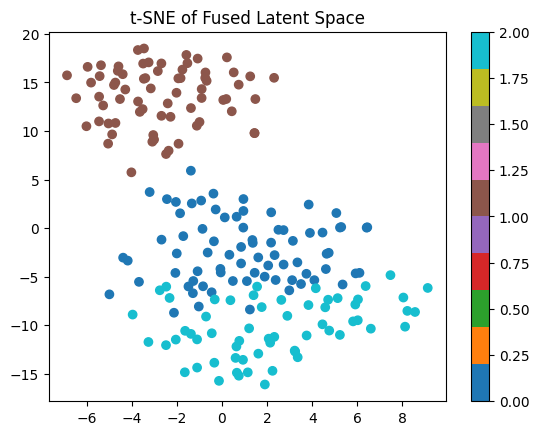

In [100]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_fused.cpu().numpy())

plt.scatter(z_2d[:,0], z_2d[:,1], c=cluster_labels, cmap="tab10")
plt.colorbar()
plt.title("t-SNE of Fused Latent Space")
plt.show()

# Supervised Machine Learning Evaluation

Now let's train multiple classifiers on the fused features and evaluate with detailed metrics.

In [101]:
# Load subtype labels
labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Filter data and labels to common samples
labels = labels_df.loc[common_samples].values.ravel()
z_fused_labeled = z_fused.cpu().numpy()

# If data was already aligned, we might need to reindex
if len(common_samples) < len(gene_df):
    # Refilter if needed
    gene_idx = gene_df.index.get_indexer(common_samples)
    z_fused_labeled = z_fused.cpu().numpy()[gene_idx]

print(f"Final data shape: {z_fused_labeled.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

Samples with labels: 205
Final data shape: (205, 192)
Labels shape: (205,)
Unique classes: [0 1 2 3]
Class distribution: [53 22 96 34]


Embeddings shape: (205, 192)
Labels shape: (205,)
Unique labels: [0 1 2 3]
Computing PCA...
Computing t-SNE...


C:\Users\shini\AppData\Local\Temp\ipykernel_4692\3721798840.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 2].set_xticklabels(omic_contributions.keys(), rotation=45)


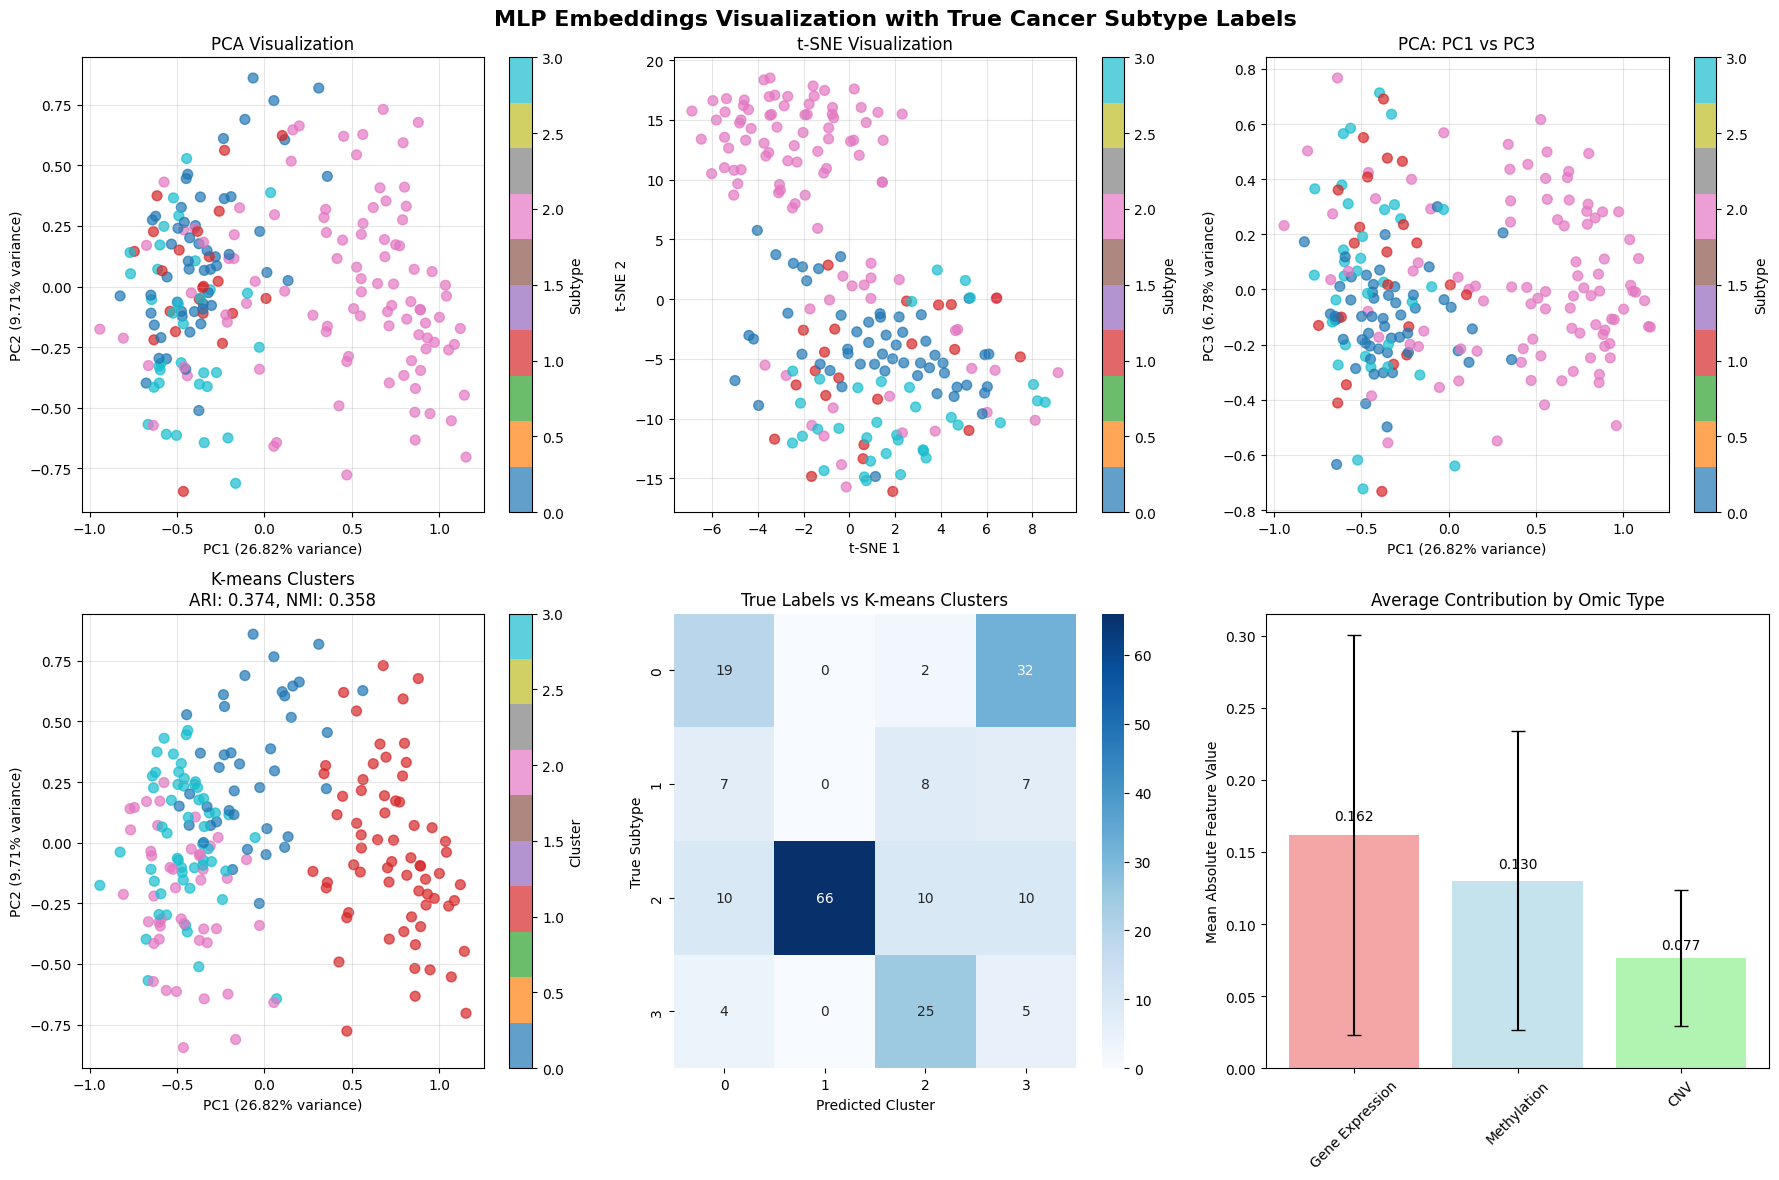

In [102]:
# Visualize embeddings with actual labels
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Get the fused embeddings and labels
embeddings = z_fused_labeled
true_labels = labels

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {true_labels.shape}")
print(f"Unique labels: {np.unique(true_labels)}")

# Create label names (assuming 0,1,2,3 are different cancer subtypes)
label_names = {0: 'Subtype 0', 1: 'Subtype 1', 2: 'Subtype 2', 3: 'Subtype 3'}
colored_labels = [label_names.get(int(label), f'Subtype {int(label)}') for label in true_labels]

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('MLP Embeddings Visualization with True Cancer Subtype Labels', fontsize=16, fontweight='bold')

# 1. PCA 2D visualization
print("Computing PCA...")
pca_2d = PCA(n_components=2, random_state=42)
embeddings_pca_2d = pca_2d.fit_transform(embeddings)

scatter1 = axes[0, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[0, 0].set_title('PCA Visualization')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Subtype')

# 2. t-SNE 2D visualization
print("Computing t-SNE...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne_2d = tsne_2d.fit_transform(embeddings)

scatter2 = axes[0, 1].scatter(embeddings_tsne_2d[:, 0], embeddings_tsne_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')
axes[0, 1].set_title('t-SNE Visualization')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Subtype')

# 3. PCA 3D to 2D projections (PC1 vs PC3)
pca_3d = PCA(n_components=3, random_state=42)
embeddings_pca_3d = pca_3d.fit_transform(embeddings)

scatter3 = axes[0, 2].scatter(embeddings_pca_3d[:, 0], embeddings_pca_3d[:, 2], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 2].set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 2].set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
axes[0, 2].set_title('PCA: PC1 vs PC3')
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[0, 2], label='Subtype')

# 4. Cluster analysis comparison
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Perform K-means clustering
n_clusters = len(np.unique(true_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings)

# Calculate clustering metrics
ari_score = adjusted_rand_score(true_labels, predicted_clusters)
nmi_score = normalized_mutual_info_score(true_labels, predicted_clusters)

scatter4 = axes[1, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=predicted_clusters, cmap='tab10', alpha=0.7, s=50)
axes[1, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[1, 0].set_title(f'K-means Clusters\nARI: {ari_score:.3f}, NMI: {nmi_score:.3f}')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 0], label='Cluster')

# 5. Side-by-side comparison: True vs Predicted
# Create a subplot for confusion-like comparison
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_clusters)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted Cluster')
axes[1, 1].set_ylabel('True Subtype')
axes[1, 1].set_title('True Labels vs K-means Clusters')

# 6. Feature importance heatmap (top features from each omic)
# Show contribution of each omic type to the fused representation
omic_contributions = {
    'Gene Expression': embeddings[:, :64].mean(axis=0),  # First 64 features from gene MLP
    'Methylation': embeddings[:, 64:128].mean(axis=0),   # Next 64 features from meth MLP  
    'CNV': embeddings[:, 128:192].mean(axis=0)           # Last 64 features from cnv MLP
}

omic_means = [np.mean(np.abs(contrib)) for contrib in omic_contributions.values()]
omic_stds = [np.std(np.abs(contrib)) for contrib in omic_contributions.values()]

bars = axes[1, 2].bar(omic_contributions.keys(), omic_means, 
                      yerr=omic_stds, capsize=5, alpha=0.7, 
                      color=['lightcoral', 'lightblue', 'lightgreen'])
axes[1, 2].set_ylabel('Mean Absolute Feature Value')
axes[1, 2].set_title('Average Contribution by Omic Type')
axes[1, 2].set_xticklabels(omic_contributions.keys(), rotation=45)

# Add value labels on bars
for bar, mean_val in zip(bars, omic_means):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.05,
                    f'{mean_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [103]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix, roc_auc_score)
import seaborn as sns

# C-index calculation function
def concordance_index(y_true, y_pred_proba):
    """
    Calculate C-index (Concordance Index) for multi-class classification.
    Uses macro-averaged AUC for multi-class problems.
    """
    try:
        # For multi-class, use macro-averaged AUC as C-index
        c_index = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
        return c_index
    except:
        return 0.0

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    z_fused_labeled, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training class distribution: {np.bincount(y_train.astype(int))}")
print(f"Test class distribution: {np.bincount(y_test.astype(int))}")

Training set size: 164
Test set size: 41
Training class distribution: [42 18 77 27]
Test class distribution: [11  4 19  7]


In [104]:
# Define multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

# Store results
results = []

print("Training and evaluating classifiers...\n")

for name, clf in classifiers.items():
    # print(f"\n{name}:")
    # print("-"*80)
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    c_index = concordance_index(y_test, y_pred_proba)
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'C-Index': c_index
    })


Training and evaluating classifiers...



f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [105]:
# Native MLP Classifiers
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[128, 64], dropout=0.3):
        super(MLPClassifier, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_mlp_classifier(model, X_train, y_train, X_test, y_test, epochs=200, patience=15):
    """Train MLP classifier with early stopping"""
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_test_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        
        train_acc = train_correct / train_total
        scheduler.step(test_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model

# Train different MLP architectures
num_classes = len(np.unique(labels))
input_dim = z_fused_labeled.shape[1]

print("Training Native MLP Classifiers...")
print("-" * 50)

# Shallow MLP
shallow_mlp = MLPClassifier(input_dim, num_classes, hidden_dims=[64], dropout=0.2).to(device)
print("Training Shallow MLP...")
shallow_mlp = train_mlp_classifier(shallow_mlp, X_train, y_train, X_test, y_test)

# Deep MLP
deep_mlp = MLPClassifier(input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3).to(device)
print("\nTraining Deep MLP...")
deep_mlp = train_mlp_classifier(deep_mlp, X_train, y_train, X_test, y_test)

def evaluate_mlp(model, X_test, y_test, model_name):
    """Evaluate MLP and return metrics"""
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        y_pred = predicted.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro
    }

# Evaluate all MLP models
mlp_results = []
mlp_results.append(evaluate_mlp(shallow_mlp, X_test, y_test, "Shallow MLP"))
mlp_results.append(evaluate_mlp(deep_mlp, X_test, y_test, "Deep MLP"))

print("\n" + "="*80)
print("NATIVE MLP CLASSIFICATION RESULTS")
print("="*80)
mlp_results_df = pd.DataFrame(mlp_results)
print(mlp_results_df.to_string(index=False))

Training Native MLP Classifiers...
--------------------------------------------------
Training Shallow MLP...
Early stopping at epoch 19

Training Deep MLP...
Early stopping at epoch 35

NATIVE MLP CLASSIFICATION RESULTS
      Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)
Shallow MLP  0.780488            0.79366           0.780488        0.659732        0.780488    0.665719    0.780488
   Deep MLP  0.756098            0.64697           0.756098        0.646574        0.756098    0.636905    0.756098


In [106]:
# Combine Traditional ML and Native MLP Results
print("\n" + "="*80)
print("COMBINED RESULTS: TRADITIONAL ML vs NATIVE MLPs")
print("="*80)

# Combine all results
all_results = results + mlp_results
combined_df = pd.DataFrame(all_results)
combined_df = combined_df.sort_values('Accuracy', ascending=False)

print(combined_df.to_string(index=False))




COMBINED RESULTS: TRADITIONAL ML vs NATIVE MLPs
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
K-Nearest Neighbors  0.804878           0.785714           0.804878        0.736030        0.804878    0.752914    0.804878 0.937366
          SVM (RBF)  0.780488           0.549342           0.780488        0.619959        0.780488    0.579553    0.780488 0.890514
        Shallow MLP  0.780488           0.793660           0.780488        0.659732        0.780488    0.665719    0.780488      NaN
        Naive Bayes  0.780488           0.697222           0.780488        0.709074        0.780488    0.697091    0.780488 0.895259
       SVM (Linear)  0.780488           0.549342           0.780488        0.619959        0.780488    0.579553    0.780488 0.905793
           Deep MLP  0.756098           0.646970           0.756098        0.646574        0.756098    0.636905    0.756098      NaN
Logistic Regression 

In [107]:
# Enhanced Results Table with C-Index Highlighted
print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON WITH C-INDEX SCORES")
print("="*100)

# Sort by C-Index for additional perspective
combined_df_c_index = combined_df.sort_values('C-Index', ascending=False)

print("\n🏆 RANKING BY C-INDEX (Discriminative Ability):")
print("-"*100)
print(combined_df_c_index[['Model', 'Accuracy', 'F1 (Macro)', 'C-Index']].to_string(index=False))

print("\n📊 DETAILED METRICS TABLE:")
print("-"*100)
print(combined_df.to_string(index=False))


COMPREHENSIVE MODEL COMPARISON WITH C-INDEX SCORES

🏆 RANKING BY C-INDEX (Discriminative Ability):
----------------------------------------------------------------------------------------------------
              Model  Accuracy  F1 (Macro)  C-Index
K-Nearest Neighbors  0.804878    0.752914 0.937366
       SVM (Linear)  0.780488    0.579553 0.905793
Logistic Regression  0.731707    0.522307 0.905147
        Naive Bayes  0.780488    0.697091 0.895259
          SVM (RBF)  0.780488    0.579553 0.890514
      Random Forest  0.731707    0.544512 0.889622
  Gradient Boosting  0.682927    0.520604 0.870855
      Decision Tree  0.682927    0.555529 0.723530
        Shallow MLP  0.780488    0.665719      NaN
           Deep MLP  0.756098    0.636905      NaN

📊 DETAILED METRICS TABLE:
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro

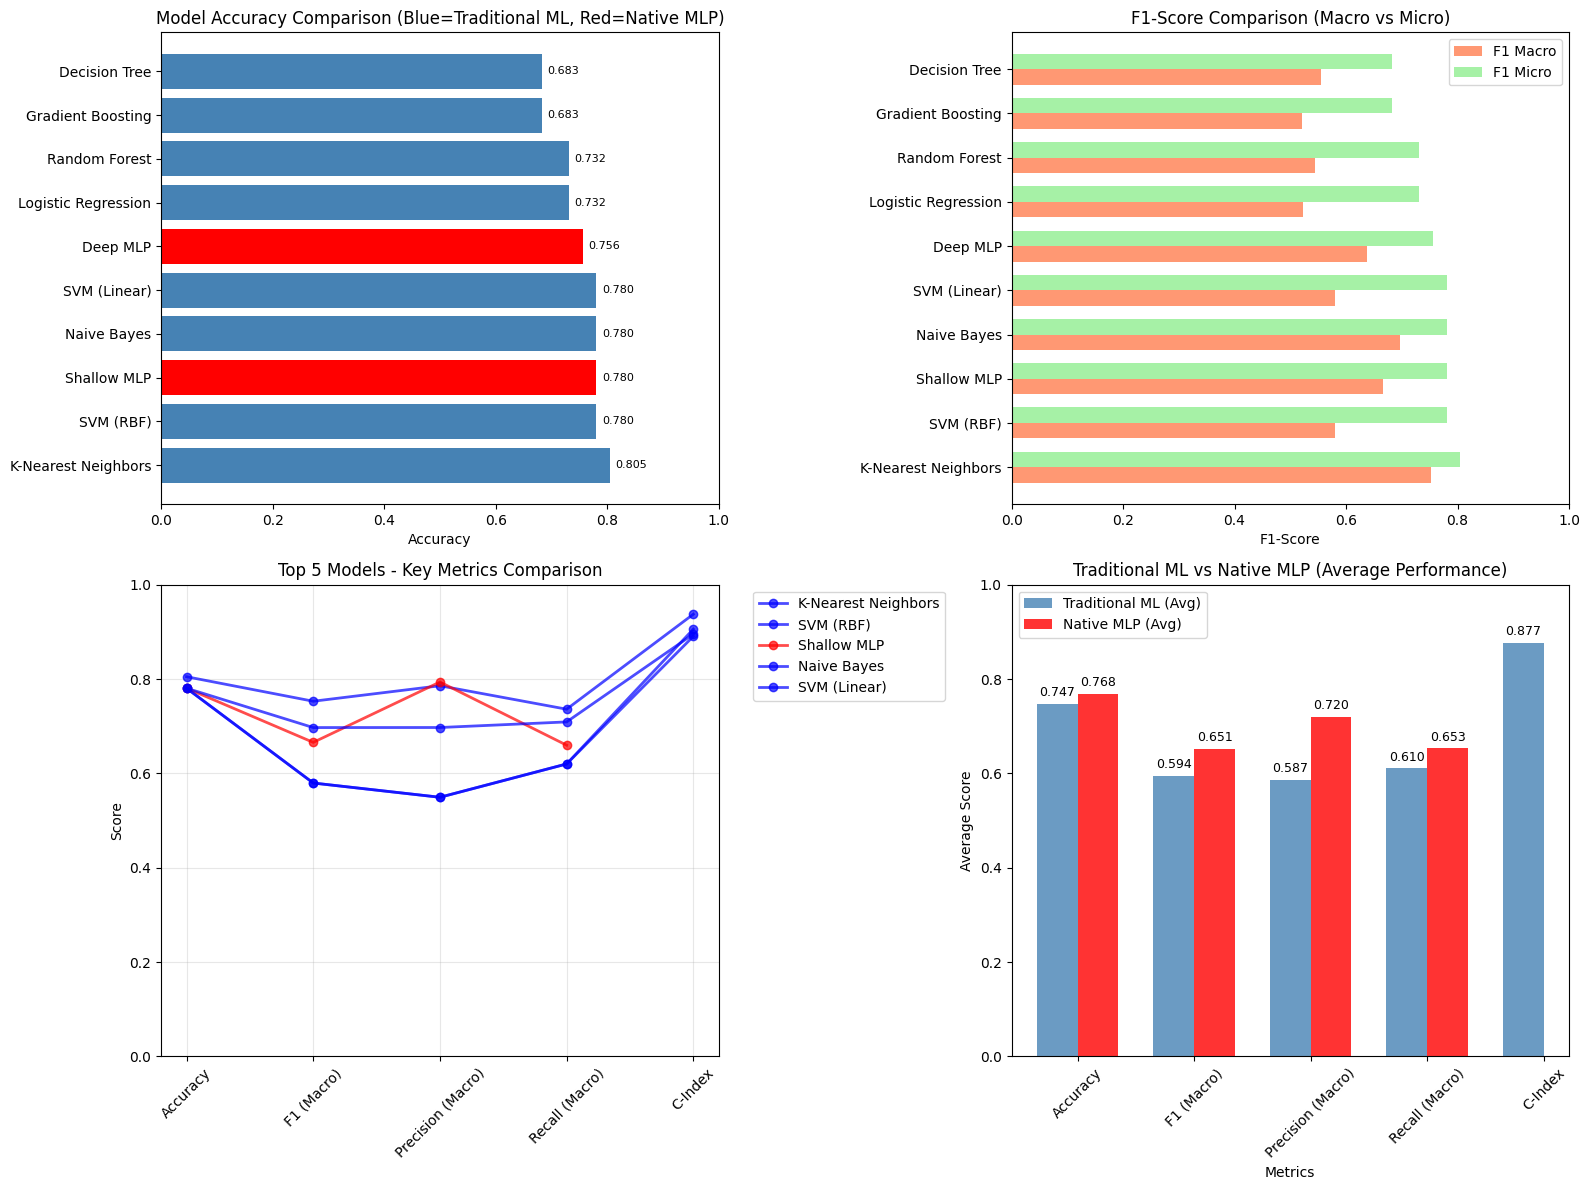

In [108]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Separate traditional ML and MLP results for color coding (ensure C-Index column exists)
traditional_ml = combined_df[~combined_df['Model'].str.contains('MLP')].copy()
native_mlp = combined_df[combined_df['Model'].str.contains('MLP')].copy()

# Plot 1: Accuracy comparison with color coding
colors = ['steelblue' if 'MLP' not in model else 'red' for model in combined_df['Model']]
bars1 = axes[0, 0].barh(combined_df['Model'], combined_df['Accuracy'], color=colors)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison (Blue=Traditional ML, Red=Native MLP)')
axes[0, 0].set_xlim([0, 1])

# Add accuracy values on bars
for i, (bar, acc) in enumerate(zip(bars1, combined_df['Accuracy'])):
    axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{acc:.3f}', va='center', fontsize=8)

# Plot 2: F1-Score comparison (Macro and Micro)
x = np.arange(len(combined_df))
width = 0.35
bars2 = axes[0, 1].barh(x - width/2, combined_df['F1 (Macro)'], width, 
                        label='F1 Macro', color='coral', alpha=0.8)
bars3 = axes[0, 1].barh(x + width/2, combined_df['F1 (Micro)'], width, 
                        label='F1 Micro', color='lightgreen', alpha=0.8)
axes[0, 1].set_yticks(x)
axes[0, 1].set_yticklabels(combined_df['Model'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison (Macro vs Micro)')
axes[0, 1].legend()
axes[0, 1].set_xlim([0, 1])

# Plot 3: Top 5 models performance radar chart style
top_5 = combined_df.head(5)
metrics = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)']
if 'C-Index' in combined_df.columns:
    metrics.append('C-Index')
x_pos = np.arange(len(metrics))

for i, (_, row) in enumerate(top_5.iterrows()):
    values = [row[metric] for metric in metrics]
    color = 'red' if 'MLP' in row['Model'] else 'blue'
    axes[1, 0].plot(x_pos, values, 'o-', label=row['Model'], 
                    linewidth=2, markersize=6, alpha=0.7, color=color)

axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(metrics, rotation=45)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Top 5 Models - Key Metrics Comparison')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Model type performance summary
# Ensure C-Index column exists before calculating averages
available_metrics = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)']
if 'C-Index' in combined_df.columns:
    available_metrics.append('C-Index')

traditional_avg = traditional_ml[available_metrics].mean()
mlp_avg = native_mlp[available_metrics].mean()

categories = available_metrics
x_pos = np.arange(len(categories))
width = 0.35

bars4 = axes[1, 1].bar(x_pos - width/2, traditional_avg, width, 
                       label='Traditional ML (Avg)', color='steelblue', alpha=0.8)
bars5 = axes[1, 1].bar(x_pos + width/2, mlp_avg, width, 
                       label='Native MLP (Avg)', color='red', alpha=0.8)

axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Average Score')
axes[1, 1].set_title('Traditional ML vs Native MLP (Average Performance)')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(categories, rotation=45)
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 1])

# Add value labels on bars
for bars in [bars4, bars5]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

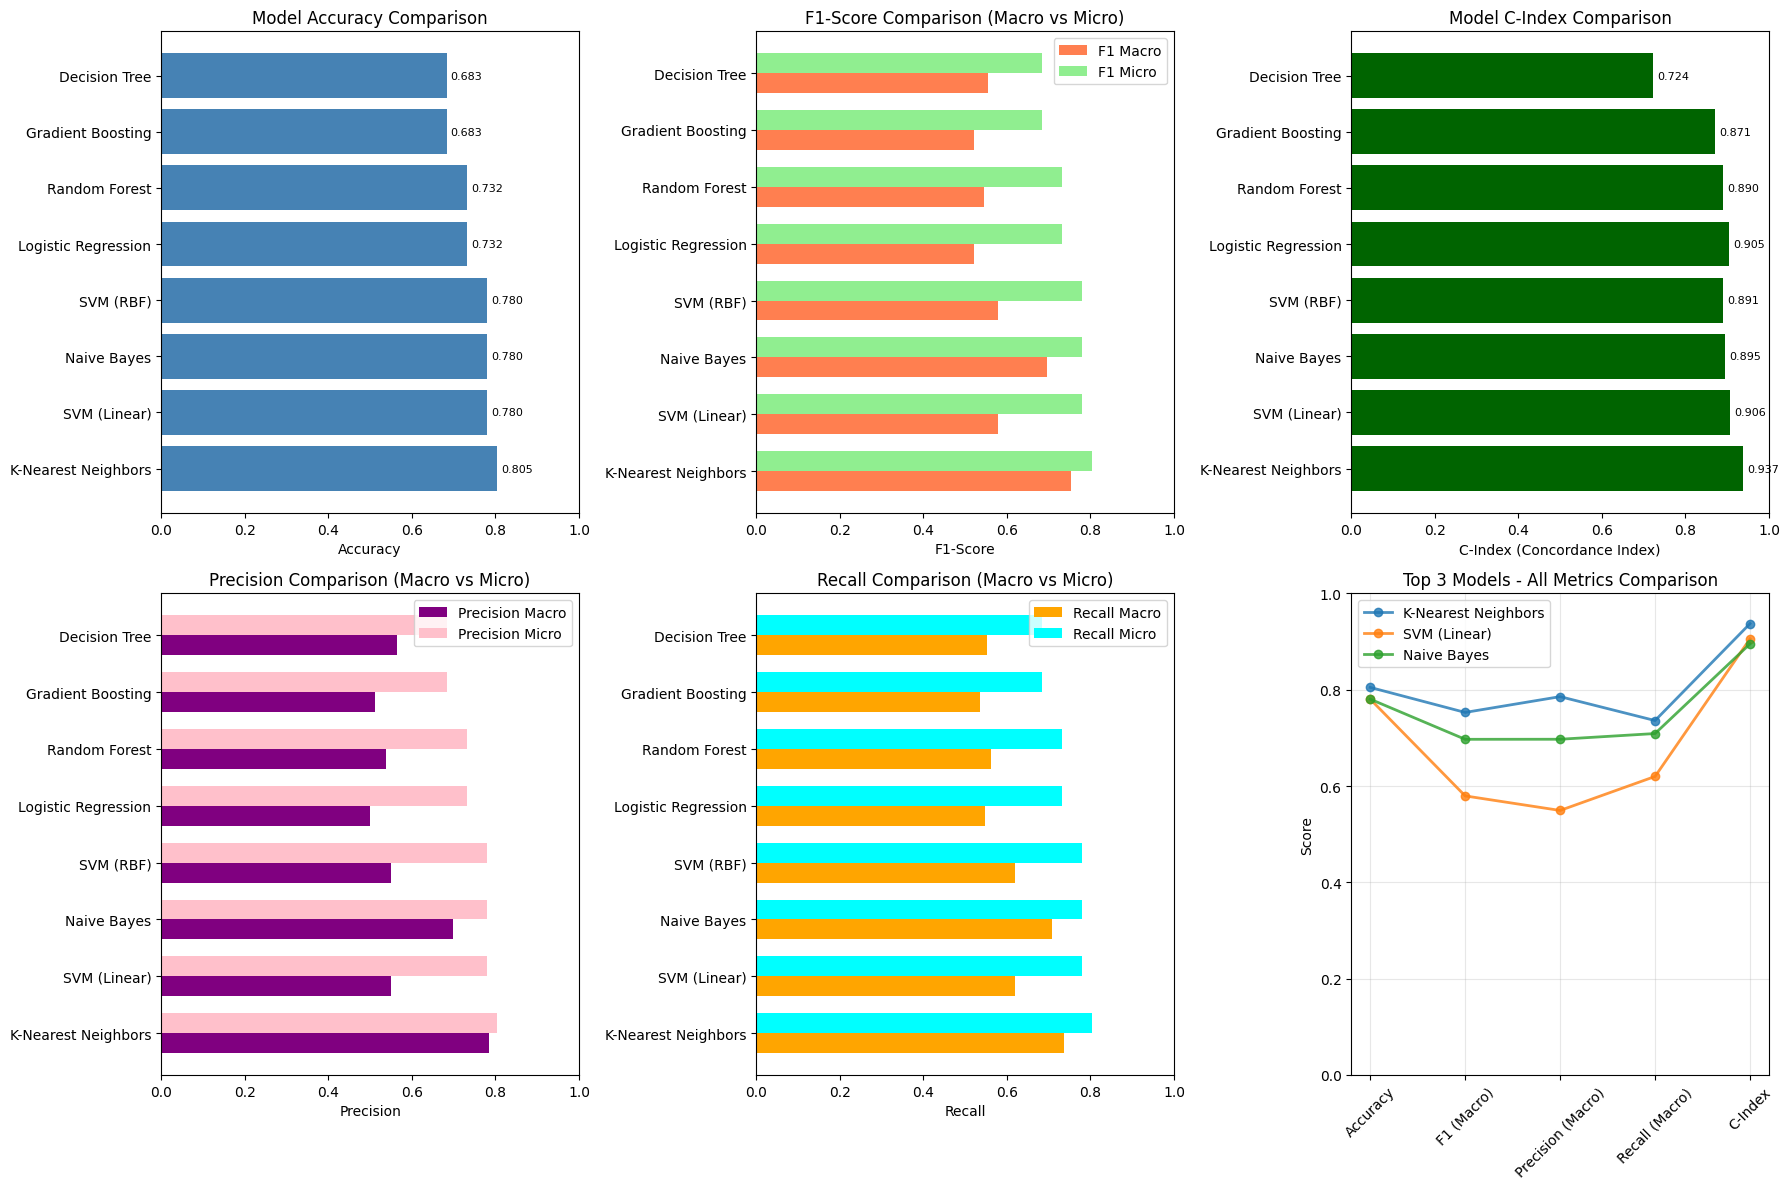

In [109]:
# Create a summary dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Accuracy comparison
bars1 = axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='steelblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim([0, 1])
# Add accuracy values on bars
for bar, acc in zip(bars1, results_df['Accuracy']):
    axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, f'{acc:.3f}', va='center', fontsize=8)

# Plot 2: F1-Score comparison (Macro and Micro)
x = np.arange(len(results_df))
width = 0.35
axes[0, 1].barh(x - width/2, results_df['F1 (Macro)'], width, label='F1 Macro', color='coral')
axes[0, 1].barh(x + width/2, results_df['F1 (Micro)'], width, label='F1 Micro', color='lightgreen')
axes[0, 1].set_yticks(x)
axes[0, 1].set_yticklabels(results_df['Model'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison (Macro vs Micro)')
axes[0, 1].legend()
axes[0, 1].set_xlim([0, 1])

# Plot 3: C-Index comparison
bars3 = axes[0, 2].barh(results_df['Model'], results_df['C-Index'], color='darkgreen')
axes[0, 2].set_xlabel('C-Index (Concordance Index)')
axes[0, 2].set_title('Model C-Index Comparison')
axes[0, 2].set_xlim([0, 1])
# Add C-index values on bars
for bar, c_idx in zip(bars3, results_df['C-Index']):
    axes[0, 2].text(c_idx + 0.01, bar.get_y() + bar.get_height()/2, f'{c_idx:.3f}', va='center', fontsize=8)

# Plot 4: Precision comparison
axes[1, 0].barh(x - width/2, results_df['Precision (Macro)'], width, label='Precision Macro', color='purple')
axes[1, 0].barh(x + width/2, results_df['Precision (Micro)'], width, label='Precision Micro', color='pink')
axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels(results_df['Model'])
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_title('Precision Comparison (Macro vs Micro)')
axes[1, 0].legend()
axes[1, 0].set_xlim([0, 1])

# Plot 5: Recall comparison
axes[1, 1].barh(x - width/2, results_df['Recall (Macro)'], width, label='Recall Macro', color='orange')
axes[1, 1].barh(x + width/2, results_df['Recall (Micro)'], width, label='Recall Micro', color='cyan')
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels(results_df['Model'])
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_title('Recall Comparison (Macro vs Micro)')
axes[1, 1].legend()
axes[1, 1].set_xlim([0, 1])

# Plot 6: Combined metrics radar chart for top 3 models
top_3 = results_df.head(3)
metrics_radar = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)', 'C-Index']
x_pos = np.arange(len(metrics_radar))

for i, (_, row) in enumerate(top_3.iterrows()):
    values = [row[metric] for metric in metrics_radar]
    axes[1, 2].plot(x_pos, values, 'o-', label=row['Model'], linewidth=2, markersize=6, alpha=0.8)

axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_radar, rotation=45)
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Top 3 Models - All Metrics Comparison')
axes[1, 2].legend()
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [110]:
# Detailed classification report for the best model
best_model_name = results_df.iloc[0]['Model']
best_clf = classifiers[best_model_name]

print(f"\n{'='*80}")
print(f"DETAILED REPORT FOR BEST MODEL: {best_model_name}")
print(f"{'='*80}\n")

# Retrain on the data (already trained, but for clarity)
y_pred_best = best_clf.predict(X_test)

# Classification report
print("Classification Report (per-class metrics):")
print("-"*80)
print(classification_report(y_test, y_pred_best, digits=4))



DETAILED REPORT FOR BEST MODEL: K-Nearest Neighbors

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.6429    0.8182    0.7200        11
           1     1.0000    0.7500    0.8571         4
           2     1.0000    0.9474    0.9730        19
           3     0.5000    0.4286    0.4615         7

    accuracy                         0.8049        41
   macro avg     0.7857    0.7360    0.7529        41
weighted avg     0.8188    0.8049    0.8065        41



In [111]:
# Cross-validation for the top 3 models
print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS (5-Fold Stratified)")
print(f"{'='*80}\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (name, clf) in enumerate(list(classifiers.items())[:3]):  # Top 3 models
    scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='f1_macro')
    roc_scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='roc_auc_ovr')
    
    print(f"{name}:")
    print(f"  Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  F1-Macro: {f1_scores.mean():.4f} (+/- {f1_scores.std():.4f})")
    print(f"  C-Index:  {roc_scores.mean():.4f} (+/- {roc_scores.std():.4f})")
    print()


CROSS-VALIDATION RESULTS (5-Fold Stratified)

Random Forest:
  Accuracy: 0.7171 (+/- 0.0700)
  F1-Macro: 0.5556 (+/- 0.0617)
  C-Index:  0.8813 (+/- 0.0619)

Gradient Boosting:
  Accuracy: 0.6537 (+/- 0.0807)
  F1-Macro: 0.5127 (+/- 0.1136)
  C-Index:  0.8492 (+/- 0.0543)

SVM (RBF):
  Accuracy: 0.7220 (+/- 0.0365)
  F1-Macro: 0.5448 (+/- 0.0317)
  C-Index:  0.8751 (+/- 0.0492)

